# Data shuffle part

__Steam Games Predictor__ by: _Kornel Zieliński, Krystian Rodzaj, Krystian Wojakiewicz_

## Introduction
The topic of our project is centered around neural networks and machine learning algorithms. We decided to work in the _active_ mode. After we had decided the basic topic of the project, the first thing that came to mind was the __Kaggle__ portal, which holds large amounts of datasets usable for data analysis and machine learning. The key was to pick such dataset, for which we would be able to accurately test our results, as well as keep the dataset relatively small, for practical purposes. We decided on a dataset containing video games details fetched from the __Steam__ gaming service using their API. The dataset is just under one year old. This creates an opportunity for us to later test our results using the same __Steam API__ to gather newer data on recently released games and treat them as input for our algorithms.

## Data load and its structure

Firstly, we imported some helpful libraries and defined global variables. Variable names are pretty much self-explanatory, __Numpy__ library was imported to help with mathematical problems and data preprocessing, an __Os__ library provides ways of cooperating with the operating system. 

In [2]:
from __future__ import division, print_function, unicode_literals
import numpy as np
import os
import matplotlib.pyplot as plt
import json
import pprint

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

PROJECT_ROOT_DIR = "."
CHAPTER_ID = "preparing_dataset"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "pictures", CHAPTER_ID)

Then we defined some help functions. First one on the list is _save_fig_ function responsible for saving generated during the excercise images.

In [3]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving image", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Next one is the _load_data_ function that loads our csv file and saves it as _Pandas's DataFrame_. __Pandas__ library is a tool that enables data analysis and manipulation in __Python__, it provides a lot of functions and objects such as the previously mentioned __DataFrame__ that is basically a data structure built with labeled columns and rows (like an excel table or database).

In [4]:
import os
import pandas as pd

def load_data(steam_path, file):
    csv_path = os.path.join(steam_path, file)
    return pd.read_csv(csv_path, error_bad_lines=False)

Now, we can load our data and assign it to a variable creating a DataFrame object and see how it's structured. To do that we've used the prevoiusly declared load_data function and then __head()__ function of the DataFrame object. The second one returns first few rows of the DataFrame, the default value of the rows is 5 but it can be also specified inside the brackets as a function parameter.

In [5]:
steam = load_data('../data', 'steam.csv')
steam.head()

,appid,name,release_date,english,developer,publisher,platforms,required_age,categories,genres,steamspy_tags,achievements,positive_ratings,negative_ratings,average_playtime,median_playtime,owners,price
0,10,Counter-Strike,2000-11-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,124534,3339,17612,317,10000000-20000000,7.19
1,20,Team Fortress Classic,1999-04-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,3318,633,277,62,5000000-10000000,3.99
2,30,Day of Defeat,2003-05-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Valve Anti-Cheat enabled,Action,FPS;World War II;Multiplayer,0,3416,398,187,34,5000000-10000000,3.99
3,40,Deathmatch Classic,2001-06-01,1,Valve,Valve,windows;mac;linux,0,Multi-player;Online Multi-Player;Local Multi-P...,Action,Action;FPS;Multiplayer,0,1273,267,258,184,5000000-10000000,3.99
4,50,Half-Life: Opposing Force,1999-11-01,1,Gearbox Software,Valve,windows;mac;linux,0,Single-player;Multi-player;Valve Anti-Cheat en...,Action,FPS;Action;Sci-fi,0,5250,288,624,415,5000000-10000000,3.99


Great, as you can see, our csv file has been successfully loaded into the DataFrame object, we can see it consists of 14 columns, from now on these columns will be called attributes. Now we want to find out how many rows our _steam_ object has. To do that, we need use __info()__ functions from the DataFrame object that does excatly what its name says - it prints information about the DataFrame object such as:
1. name of the column,
2. number of entries (rows),
3. number of columns (attributes),
4. number of non-null values,
5. types of the attributes.

In [6]:
steam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27075 entries, 0 to 27074
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   appid             27075 non-null  int64  
 1   name              27075 non-null  object 
 2   release_date      27075 non-null  object 
 3   english           27075 non-null  int64  
 4   developer         27075 non-null  object 
 5   publisher         27075 non-null  object 
 6   platforms         27075 non-null  object 
 7   required_age      27075 non-null  int64  
 8   categories        27075 non-null  object 
 9   genres            27075 non-null  object 
 10  steamspy_tags     27075 non-null  object 
 11  achievements      27075 non-null  int64  
 12  positive_ratings  27075 non-null  int64  
 13  negative_ratings  27075 non-null  int64  
 14  average_playtime  27075 non-null  int64  
 15  median_playtime   27075 non-null  int64  
 16  owners            27075 non-null  object

Now we can see that, thankfully, our dataset does not contain any null values and we don't have to fill them in. Names of the attributes are pretty much self explanatory, but just to be precise, we need to clarify some of the most important to~us:
1. english - tells whether the given game supports english lanuague (binary attribute - 0/1),
2. platforms - tells which platform game is available (three main platforms, semicolon separated),
3. owners - tells how many gamers bought the game.

Now, seeing how the most important attributes for us are _owners_ and to be made _rating_ we can try to get some interesting information. There are some __object__ types (basically string) in our dataset that will require encoding into numerical values before looking for correlation (only numerical attributes can be used in correlation searching functions) and preprocessing with some of the machine learning algorithms (same point). Firstly, we can check some attributes without encoding them, let's do exatcly that with our owners attribute then. For that we'll use the __value_counts()__ function from the Pandas's __Series__ object. Series is a one-dimensional array, it's what a DataFrame object is made of. 

In [7]:
steam["owners"].value_counts()

0-20000                18596
20000-50000             3059
50000-100000            1695
100000-200000           1386
200000-500000           1272
500000-1000000           513
1000000-2000000          288
2000000-5000000          193
5000000-10000000          46
10000000-20000000         21
20000000-50000000          3
50000000-100000000         2
100000000-200000000        1
Name: owners, dtype: int64

Now we can see how our owners attribute is classified, of course there are 18596 games owned by 0-20000 gamers, but there's only one game owned by 100000000-200000000, that being __Dota 2__. 

Great, now let's check platforms attribute in the same way. We can also visualize this by building this attribute's histogram.

In [8]:
steam["platforms"].value_counts()

windows              18398
windows;mac;linux     4623
windows;mac           3439
windows;linux          610
mac                      3
linux                    1
mac;linux                1
Name: platforms, dtype: int64

In [ ]:
plt.figure(figsize = (12,8))
steam["platforms"].hist(bins=15)
save_fig("platforms_hist")
plt.show()

Ok, by that we can see that this attribute consists of categorical values separated by semicolon, in the next steps we'll change it into indicator variables. Lastly, we can check the ratio between english and non-english games (english ones being 1, others 0).

In [9]:
steam["english"].value_counts()

1    26564
0      511
Name: english, dtype: int64

Saving image english_hist


FileNotFoundError: [Errno 2] No such file or directory: '.\\pictures\\preparing_dataset\\english_hist.png'

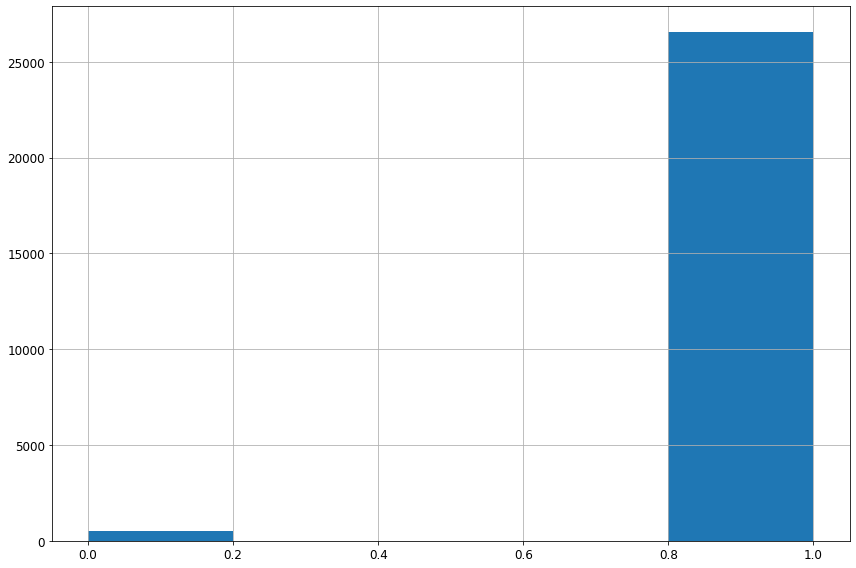

In [10]:
plt.figure(figsize = (12,8))
steam["english"].hist(bins=5)
save_fig("english_hist")
plt.show()

We can see there's only 511 non-english games in our dataset. Let's end the first phase here and continue work on our dataset after encoding string values into numerical ones.

## Encoding the data and searching for correlations

Seeing how now we start to manipulate the data best practice to do so is to work on the copy of the data, let's do exactly that and after that delete some of the attributes that won't be important for us. After a long discussion we decided that we won't need:
1. appid - it does not contain any relevant information from the machine learning point of view,
2. name - non-categorical value, it would be hard to extract some interesting information from it,
3. steamspy_tags - redundant information, same can be found in categories and genres attributes,
4. price - non-relevant information, especially at the date of the premier.

Then we used __drop()__ function from Pandas, it deletes the column specified in its parameters, in our case:

In [12]:
steam_cp = steam.copy()
steam_cp = steam_cp.drop(columns=["appid", "name", "steamspy_tags", "price"])

The next step is to encode object attributes that are important to us, we could use objects provided by the Pandas library like __LabelEncoder__, but we decided to define our own function, that will encode the entire column and also create a dictionary where we will store our labels with their keys. The function is shown below.

In [13]:
def encode_series(series):
    col = pd.Series(steam_cp[series])
    dictionary = {}
    enc_series = []
    i = 0
    for c in col:
        if c not in dictionary.keys():
            dictionary[c] = (i, c)
            i = i + 1
        x = dictionary[c][0]
        enc_series.append(x)
    return enc_series, dictionary

And then with the help of the above function we encoded the following columns: developer, publisher and owners, along with assigning some keys to its lables. The purpose of this action is to be able to easily find values of these columns and its numerical equivalents.

In [14]:
enc_dev, dev_dict = encode_series('developer')
enc_publ, publ_dict = encode_series('publisher')
enc_own, own_dict = encode_series('owners')

For future references we might need to save the produced data in a file for further analysis in later stages of the project development. The method below saves the resulting dictionaries in a specified folder.

In [15]:
def save_encoded_dict_to_file(dest_filepath, data_to_write):
    with open(dest_filepath, 'w') as f:
        out = json.dumps(data_to_write)
        f.write(pp.pformat(out))

The next columns that had to be encoded were genres and categories. However, in this case we had to use another function to encode them. Because the data was saved in the following way: dataA;dataB;dateC... we had to separate this data and create columns from it. But before this process, we checked what new, potential columns are to be created when we did it.

In [16]:
def extract_values_in_columns(column):
    col = pd.Series(steam_cp[column])
    col_value_list = []
    col_value_set = set()

    for c in col:
        col_value_list.append(c.split(";"))

    for row in col_value_list:
        for r in row:
            col_value_set.add(r)
            
    return col_value_set

Then we used this function and created sets that consisted of categorical values of the _genres_ and _categories_ columns.

In [17]:
genres_set = extract_values_in_columns("genres")
cats_set = extract_values_in_columns("categories")

First let's check _genres_ structure.

In [18]:
genres_set

{'Accounting',
 'Action',
 'Adventure',
 'Animation & Modeling',
 'Audio Production',
 'Casual',
 'Design & Illustration',
 'Documentary',
 'Early Access',
 'Education',
 'Free to Play',
 'Game Development',
 'Gore',
 'Indie',
 'Massively Multiplayer',
 'Nudity',
 'Photo Editing',
 'RPG',
 'Racing',
 'Sexual Content',
 'Simulation',
 'Software Training',
 'Sports',
 'Strategy',
 'Tutorial',
 'Utilities',
 'Video Production',
 'Violent',
 'Web Publishing'}

And then _categories_.

In [20]:
cats_set

{'Captions available',
 'Co-op',
 'Commentary available',
 'Cross-Platform Multiplayer',
 'Full controller support',
 'In-App Purchases',
 'Includes Source SDK',
 'Includes level editor',
 'Local Co-op',
 'Local Multi-Player',
 'MMO',
 'Mods',
 'Mods (require HL2)',
 'Multi-player',
 'Online Co-op',
 'Online Multi-Player',
 'Partial Controller Support',
 'Shared/Split Screen',
 'Single-player',
 'Stats',
 'Steam Achievements',
 'Steam Cloud',
 'Steam Leaderboards',
 'Steam Trading Cards',
 'Steam Turn Notifications',
 'Steam Workshop',
 'SteamVR Collectibles',
 'VR Support',
 'Valve Anti-Cheat enabled'}

After that we used the function __"get_dummies()"__, which splits strings in the Series and returns a DataFrame object of the "dummy" variables. We decided to test it on the __categories__ attribute and use semicolon as the separator, the results are shown below.

In [21]:
steam_cp["categories"].str.get_dummies(sep=';')

,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Full controller support,In-App Purchases,Includes Source SDK,Includes level editor,Local Co-op,Local Multi-Player,...,Stats,Steam Achievements,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,VR Support,Valve Anti-Cheat enabled
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27070,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
27071,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27072,0,1,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
27073,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


Next step is to create a __Rating__ attribute for our new dataset. To do that we used __positive_ratings__ and __negative_ratings__ and calculated from them the percentage of the positive ones from the total number of ratings. We decided that the ratings will resemble the Metacritic or RottenTomatoes ones (value from 0 to 100). The results of the equation were stored in the __ratings__ list that was later assigned as the attribute of the new DataFrame object with the same name.

In [22]:
pos = pd.Series(steam_cp['positive_ratings'])
neg = pd.Series(steam_cp['negative_ratings'])
ratings = []
for p, n in zip(pos, neg):
    total = p + n
    i = np.round((p/total)*100)
    ratings.append(i)

Next step was to encode __release_date__. It could be problematic but we decided, to split this column into two separate ones: __Month__ (month of release) and __Year__ (year of release). To do this, first we changed the type of the release_date with the help of __to_datetime()__ function with our Series as the first parameter and the format of the date as the second one. Then in the loop we extracted months and years values into separate lists, that were later assigned as the Series objects of the newly created DataFrame object.

In [24]:
dates = pd.Series(steam_cp['release_date'])
dates = pd.to_datetime(dates, format = '%Y-%m-%d')
months = []
years = []

for i in dates:
    d = i.month
    months.append(d)
    y = i.year
    years.append(y)

Ok, now we're ready to create a new DataFrame, without much explanation, because most of these operations have been already explained. Let's add them and check the structure of the object.

In [30]:
def produce_encoded_dataframe(relevant_attributes, attributes_to_concat, raw_data, value_sep=';'):
    encoded_data = pd.DataFrame()
    for attr in attributes_to_concat:
        encoded_data = pd.concat([encoded_data, raw_data[attr].str.get_dummies(sep=value_sep)], axis=1)

    for attr in relevant_attributes.keys():
        encoded_data[attr] = relevant_attributes[attr]
    return encoded_data

In [39]:
relevant_attributes = {'Month': months, 'Year': years,
                           'English': steam_cp['english'], 'Developer': enc_dev,
                           'Publisher': enc_publ, 'Required_Age': steam_cp['required_age'],
                           'Achievements': steam_cp['achievements'], 'Average_Playtime': steam_cp['average_playtime'],
                           'Median_Playtime': steam_cp['median_playtime'], 'Rating': ratings, 'Owners': enc_own}
attributes_to_concat = ['genres', 'categories', 'platforms']

In [59]:
enc_data = produce_encoded_dataframe(relevant_attributes, attributes_to_concat, steam_cp)
enc_data.head(8)

,Accounting,Action,Adventure,Animation & Modeling,Audio Production,Casual,Design & Illustration,Documentary,Early Access,Education,...,Year,English,Developer,Publisher,Required_Age,Achievements,Average_Playtime,Median_Playtime,Rating,Owners
0,0,1,0,0,0,0,0,0,0,0,...,2000,1,0,0,0,0,17612,317,97.0,0
1,0,1,0,0,0,0,0,0,0,0,...,1999,1,0,0,0,0,277,62,84.0,1
2,0,1,0,0,0,0,0,0,0,0,...,2003,1,0,0,0,0,187,34,90.0,1
3,0,1,0,0,0,0,0,0,0,0,...,2001,1,0,0,0,0,258,184,83.0,1
4,0,1,0,0,0,0,0,0,0,0,...,1999,1,1,0,0,0,624,415,95.0,1
5,0,1,0,0,0,0,0,0,0,0,...,2000,1,0,0,0,0,175,10,80.0,1
6,0,1,0,0,0,0,0,0,0,0,...,1998,1,0,0,0,0,1300,83,96.0,1
7,0,1,0,0,0,0,0,0,0,0,...,2004,1,0,0,0,0,427,43,89.0,0


Having a DataFrame that only has numerical values, we were able to look for correlations. The first step is to create a correlation matrix. To do that we used the __corr()__ function of the DataFrame object. We used it on our DataFrame and checked how it looked.

In [60]:
corr_matrix = enc_steam.corr()
corr_matrix

,Month,Year,English,Developer,Publisher,linux,mac,windows,Required_Age,Captions available,...,Tutorial,Utilities,Video Production,Violent,Web Publishing,Achievements,Average_Playtime,Median_Playtime,Rating,Owners
Month,1.000000,-0.156352,0.018501,-0.026496,-0.025305,0.001113,0.008372,0.005324,0.000078,0.007726,...,0.007807,-0.002784,0.000255,-0.004256,0.006127,-0.012066,0.003627,0.003098,-0.000520,0.003422
Year,-0.156352,1.000000,-0.086886,0.683466,0.621191,-0.082492,-0.088161,0.001878,-0.078865,-0.029900,...,0.004232,0.005910,0.000490,0.054826,-0.006897,0.034243,-0.052997,-0.034508,-0.007915,0.392090
English,0.018501,-0.086886,1.000000,-0.119559,-0.124342,0.055533,0.061267,-0.001885,0.002860,0.017883,...,0.000843,0.002800,-0.002050,0.007674,-0.003982,0.014121,0.000338,-0.003416,-0.017604,-0.035323
Developer,-0.026496,0.683466,-0.119559,1.000000,0.898659,-0.175826,-0.166639,0.001957,-0.081207,-0.084384,...,0.001292,0.013793,0.006374,0.050410,-0.000749,0.025707,-0.064034,-0.045295,-0.032305,0.385578
Publisher,-0.025305,0.621191,-0.124342,0.898659,1.000000,-0.160122,-0.152857,0.000264,-0.077613,-0.074229,...,0.001621,0.018617,0.010302,0.048478,-0.001594,0.023436,-0.059452,-0.042361,-0.032769,0.362980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Achievements,-0.012066,0.034243,0.014121,0.025707,0.023436,-0.009535,-0.023553,0.001220,-0.005459,-0.007753,...,-0.000763,-0.008898,-0.004558,0.003008,-0.003923,1.000000,0.014175,0.009957,-0.022506,0.001132
Average_Playtime,0.003627,-0.052997,0.000338,-0.064034,-0.059452,0.031488,0.027909,0.001114,0.034423,0.022218,...,-0.000498,-0.001501,-0.002520,-0.009975,-0.000239,0.014175,1.000000,0.914900,0.020349,-0.099681
Median_Playtime,0.003098,-0.034508,-0.003416,-0.045295,-0.042361,0.021210,0.019626,0.000843,0.014748,0.021788,...,-0.000377,0.000037,-0.001859,-0.007377,-0.000105,0.009957,0.914900,1.000000,0.013172,-0.057879
Rating,-0.000520,-0.007915,-0.017604,-0.032305,-0.032769,0.116379,0.122155,-0.004738,0.010169,0.029928,...,-0.005580,-0.008140,-0.009889,-0.063875,0.004982,-0.022506,0.020349,0.013172,1.000000,-0.045532


Well, a correlation matrix has been created but it's not very readable, we checked how it looked for attributes that are the most interesting to us, Owners and Rating.

In [61]:
corr_matrix["Rating"].sort_values(ascending=False)

Rating                     1.000000
Steam Cloud                0.182635
Steam Achievements         0.160252
Full controller support    0.140914
mac                        0.122155
                             ...   
MMO                       -0.051557
In-App Purchases          -0.053645
Violent                   -0.063875
Massively Multiplayer     -0.072636
Simulation                -0.113912
Name: Rating, Length: 72, dtype: float64

In [62]:
corr_matrix["Owners"].sort_values(ascending=False)

Owners                 1.000000
Year                   0.392090
Developer              0.385578
Publisher              0.362980
Indie                  0.127370
                         ...   
Steam Cloud           -0.120236
In-App Purchases      -0.127851
Multi-player          -0.145272
Free to Play          -0.189014
Steam Trading Cards   -0.298738
Name: Owners, Length: 72, dtype: float64

Ok, we can see that for the Rating attribute, the strongest correlation was shown between genres and categories values. And for the owners it was the year of release, developers and publishers. 
Great, DataFrame prepared in that way is ready to be proccesed with the machine learning algorithms. The last step is to save this DataFrame into a new file that can be used in the future.

In [29]:
enc_steam.to_csv('../data/enc_steam.csv')